In [2]:
from time import sleep

import numpy as np
from matplotlib import pyplot as plt
import random
import time
from matplotlib.animation import FuncAnimation

In [3]:
class Robot:
    def __init__(self, b=1.0, velocity_noise=False, odometry_noise=False,
                 sigma_right=0.01, sigma_left=0.01, drive_in_circles=False):
        self.axis_length = b
        self.velocity_noise = velocity_noise
        self.odometry_noise = odometry_noise
        self.sigma_right = sigma_right
        self.sigma_left = sigma_left
        self.drive_in_circles = drive_in_circles

        self.velocity = [1.0, 1.0]  # [v_l, v_r]
        self.true_state = [0.0, 0.0, 0.0]
        self.estimated_state = [0.0, 0.0, 0.0]

        self.true_trajectory = []
        self.odometry_trajectory = []

    def _get_noisy_velocity(self):
        if self.drive_in_circles:
            self.velocity = [1.0, 0.5]

        if self.velocity_noise:
            v_l = self.velocity[0] + np.random.normal(0, self.sigma_left)
            v_r = self.velocity[1] + np.random.normal(0, self.sigma_right)
        else:
            v_l, v_r = self.velocity

        self.noisy_velocity = [v_l, v_r]

    def move(self, dt=1.0):
        self._get_noisy_velocity()
        v_l, v_r = self.noisy_velocity
        theta = self.true_state[2]

        delta_x = 0.5 * (np.cos(theta) * v_l + np.cos(theta) * v_r) * dt
        delta_y = 0.5 * (np.sin(theta) * v_l + np.sin(theta) * v_r) * dt
        delta_theta = ((v_l - v_r) / self.axis_length) * dt

        prev_true_state = self.true_state.copy()
        self.true_state[0] += delta_x
        self.true_state[1] += delta_y
        self.true_state[2] += delta_theta
        if self.true_state[2] > 360 or self.true_state[2] < 0:
            print(self.true_state)

        self._update_odometry(prev_true_state)
        self._log_trajectory()

    def _update_odometry(self, prev_true_state):
        delta_x = self.true_state[0] - prev_true_state[0]
        delta_y = self.true_state[1] - prev_true_state[1]
        delta_theta = self.true_state[2] - prev_true_state[2]

        if self.odometry_noise:
            delta_x += np.random.normal(0, 0.01)
            delta_y += np.random.normal(0, 0.01)
            delta_theta += np.random.normal(0, 0.01)

        self.estimated_state[0] += delta_x
        self.estimated_state[1] += delta_y
        self.estimated_state[2] += delta_theta

    def _log_trajectory(self):
        self.true_trajectory.append((self.true_state[0], self.true_state[1]))
        self.odometry_trajectory.append((self.estimated_state[0], self.estimated_state[1]))


In [4]:
from os import wait


def animate_robots(num_robots=5, steps=100, interval=100,
                   velocity_noise=True, odometry_noise=False,
                   drive_in_circles=False):
    robots = [Robot(velocity_noise=velocity_noise,
                    odometry_noise=odometry_noise,
                    drive_in_circles=drive_in_circles,
                    sigma_left=0.05,
                    sigma_right=0.05)
              for _ in range(num_robots)]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-10, 60)
    ax.set_ylim(-30, 30)
    ax.set_aspect('equal')
    ax.set_title("Real-time Robot Simulation")

    # Each robot has: a trajectory line and an orientation arrow
    trajectory_lines = [ax.plot([], [], label=f"Robot {i+1}")[0] for i in range(num_robots)]
    robot_heads = [ax.arrow(0, 0, 0, 0, head_width=0.4, color=trajectory_lines[i].get_color())
                   for i in range(num_robots)]

    def init():
        for line in trajectory_lines:
            line.set_data([], [])
        return trajectory_lines + robot_heads

    def update():
        print("hi")
        for i, bot in enumerate(robots):
            bot.move()

            traj = np.array(bot.odometry_trajectory)
            # print("Traj: ", traj)
            trajectory_lines[i].set_data(traj[:, 0], traj[:, 1])

            # Update arrow
            if len(traj) > 0:
                x, y, theta = bot.estimated_state
                arrow = robot_heads[i]
                arrow.remove()
                dx = 1.0 * np.cos(theta)
                dy = 1.0 * np.sin(theta)
                robot_heads[i] = ax.arrow(x, y, dx, dy, head_width=0.4, color=trajectory_lines[i].get_color())

        return trajectory_lines + robot_heads

    ani = FuncAnimation(fig, update(), frames=steps, init_func=init(),
                        interval=interval, blit=False, repeat=False)
    plt.legend()
    plt.show()
    return ani


hi


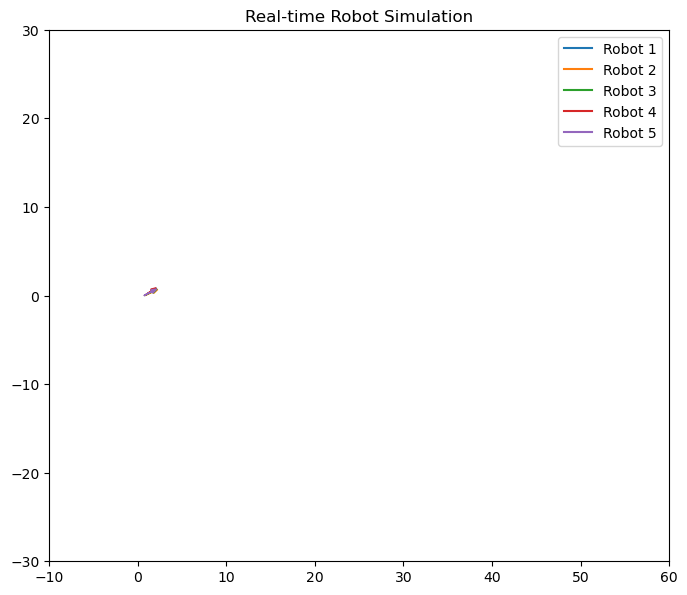

In [5]:
# --- Run the animation ---

ani = animate_robots(
    num_robots=5,
    steps=10,
    interval=1,  # ms between frames
    velocity_noise=True,
    odometry_noise=False,
    drive_in_circles=True  # Toggle to False for straight motion
)